## **Hentsch Manifold 3D Visual Explorer**
---
This interactive 3D tool visualizes the structure of the Hentsch Manifold, including its algebraic null cone and canonical deformation fields. It is designed to support geometric intuition behind the projected and embedded flows described in the paper.
### **Controls**
| Parameter        | Description |
|------------------|-------------|
| **ε (epsilon)**  | Shear strength controlling the linear deformation field. Critical shear occurs at \( \epsilon_c = 1/\sqrt{6} \). |
| **θ (theta)**    | Shear direction angle (in parameter space). Rotates the shear field. |
| **Q level**      | Level-set value \( Q(a, c, e) = q \) for deforming the cone surface. \( Q = 0 \) defines the null cone. |
| **scale**        | Controls the overall spatial extent of the view. |
| **Projection**   | Choose between perspective and orthographic projection. |
| **Elev° / Azim°**| Controls the 3D camera elevation and azimuth angles. |
| **show_cone**    | Displays the algebraic null cone surface (marching-cube extracted). |
| **show_wireframe**| Displays a thin reference cone wireframe for orientation. |
| **show_basis**   | Shows orthogonal shear basis vectors (in blue). |
| **show_vectors3d**| Toggles display of the full 3D deformation vector field. |
| **show_canonical_vector_field** | Toggle canonical (non-sheared) cone-preserving field. |
| **show_shear_vector_field** | Toggle the shear-only vector field. |
| **show_combined_vector_field** | Toggle the total (canonical + shear) vector field. |
| **Axes a–f**     | Show/hide the individual coordinate axes in the \((a, c, e)\) and imaginary planes. |
| **show_planes**  | Displays the three complex coordinate planes \((a+ib), (c+id), (e+if)\). |
| **show_screen_planes** | Shows the ℓ⊥ screen planes used in projection. |
---
### **Visual Aids**
- **ℓ axis** (color-coded): The degenerate axis of the null cone.
- **Circular sections**: Represent constant-ℓ slices through the cone (diagnostic).
- **Blue arrows**: Orthonormal basis vectors \(\vec{v}_1, \vec{v}_2\) in ℓ⊥ screen space.
- **Colored quiver**: Visualizes vector field deformation.
---
### **Tips**
- Toggle **combined vector field** and adjust **ε** to explore the onset of null point dynamics.
- Use **θ** to rotate the deformation direction and test \( Z_3 \) symmetry.
- Toggle **planes** and **axes** to understand the complex structure and how it aligns with real axes.
- Set **Projection = ortho** to match analytic plots more closely.
---

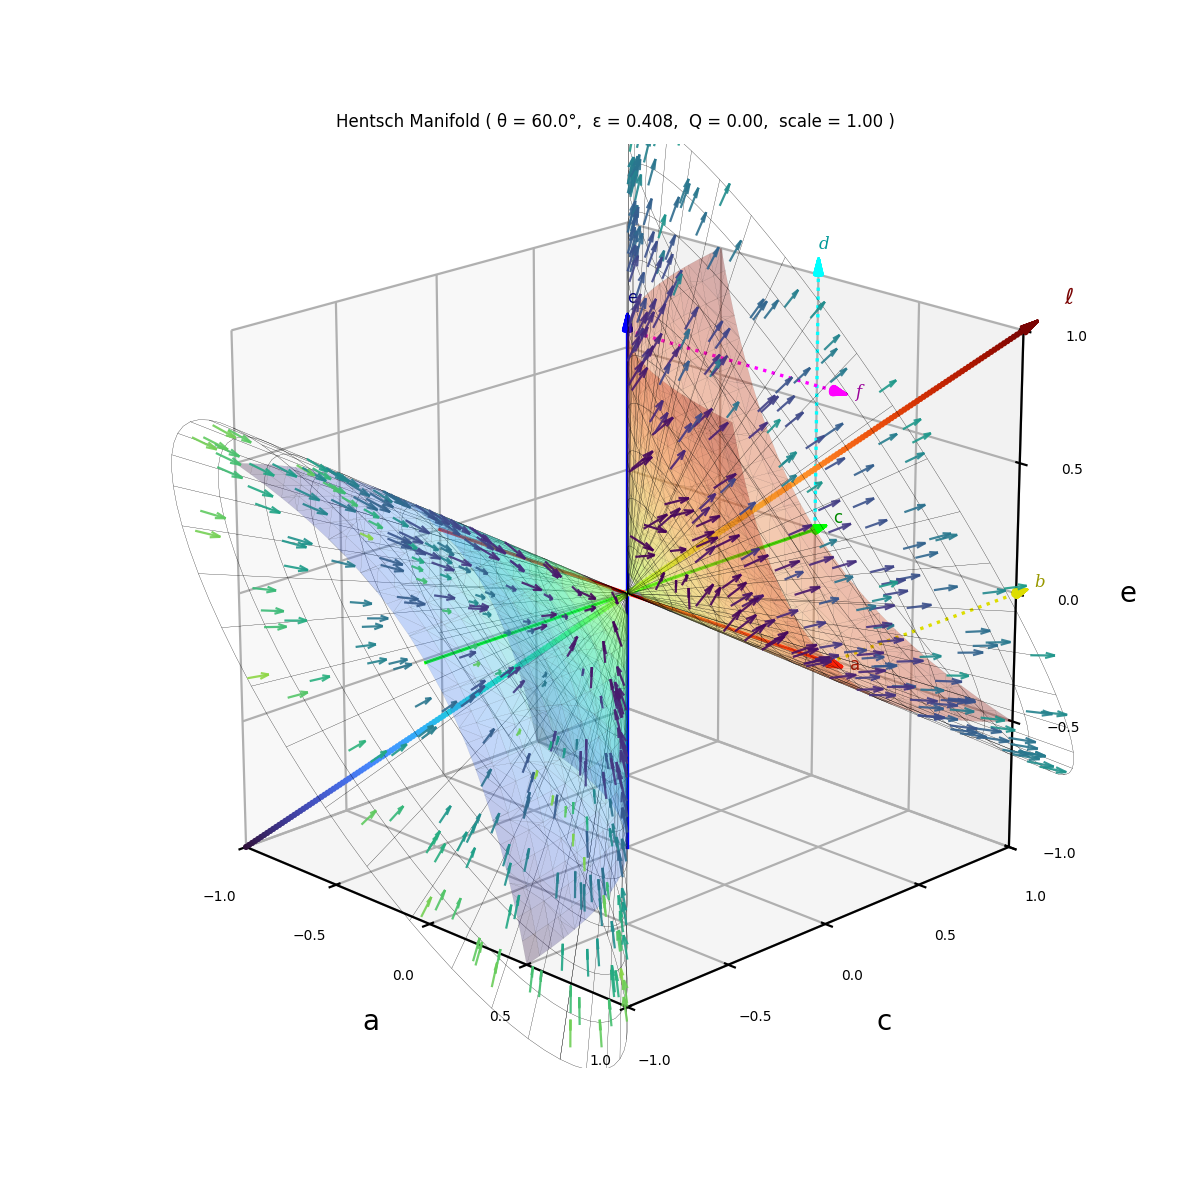

In [1]:
# --- Hentsch Manifold Explorer script ---
%matplotlib widget
# ==============================================================================
# IMPORTS
# ==============================================================================
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
import matplotlib.colors as mcolors
import numpy.random as npr
from numpy.linalg import inv
import ipywidgets as widgets
from IPython.display import display
# ==============================================================================
# CONFIGURATION (CFG)
# ==============================================================================
CFG = {
    # ---- figure / output --------------------------------------------
    "figsize": (6, 6),
    "dpi": 200,
    "save": False,
    "save_dpi": 300,
    "save_prefix": "figure_",

    # ---- camera presets ---------------------------------------------
    "presets": [
        ("persp", 25, -45),
    ],
    "shear_theta_deg":  60,
    "theta_range": [],

    # ---- extra parameters for vector field ----
    "epsilon": 1/np.sqrt(6),
    "epsilon_range": [],

    # ---- plot bounds & axes -----------------------------------------
    "scale_factor": 1.0,
    "zoom": 1.0,
    "aspect_ratio": (1, 1, 1),

    # ---- arrow styling ----------------------------------------------
    "arrow_cone_height": 0.06,
    "arrow_cone_radius": 0.015,

    # ---- colours & cmaps --------------------------------------------
    "screen_cmap": "turbo",
    "field_cmap":  "viridis",

    # ---- feature toggles --------------------------------------------
    "show_cone":         True,
    "show_wireframe":    True,
    "show_basis":        False,
    "reorient_vertical": False,
    "quadric_level":     0.0,
    "show_vectors3d":    True,
    "show_canonical_vector_field": False,
    "show_shear_vector_field": False,
    "show_combined_vector_field": True,
    "s_value": 0.5,  # for screen plane cross-section
    "quiver_num": 800,  # number of points in the vector field

    # -- choose which coordinate axes to show
    "show_axes": dict(a=True, b=True, c=True, d=True, e=True, f=True),
    "show_planes": False,
}
CFG["show_screen_planes"] = False if CFG.get("reorient_vertical", 0) else False

# ==============================================================================
# ==============================================================================
# DERIVED CONSTANTS
# ==============================================================================
figure_width, figure_height = CFG["figsize"]
figure_dpi                 = CFG["dpi"]
save_fig                   = CFG["save"]
save_dpi                   = CFG["save_dpi"]
color_map  = CFG["screen_cmap"]
field_cmap = CFG["field_cmap"]
show_basis       = CFG["show_basis"]
show_cone        = CFG["show_cone"]
show_wireframe   = CFG["show_wireframe"]
show_vectors3d   = CFG["show_vectors3d"]
show_planes      = CFG["show_planes"]
(show_a, show_b, show_c, show_d, show_e, show_f) = tuple(CFG["show_axes"][k] for k in "abcdef")


# ==============================================================================
# HELPER CONSTANTS AND LABELS
# ==============================================================================
import os
from datetime import datetime
script_dir = os.path.dirname(os.getcwd())
span = np.linspace(-1, 1, 2)
tick_size = 5
plane_alpha = 0.1
ell_resolution = 250
cone_resolution = 25
cone_transparency = 0.3
wireframe_scale = 1 #if CFG["reorient_vertical"] else 0.86
reorient_vertical = CFG["reorient_vertical"]
field_canonical = 1 if CFG.get("show_canonical_vector_field", False) else 0
field_shear = 1 if CFG.get("show_shear_vector_field", False) else 0
show_all = 1
show_real = 1
show_imag = 1
superposed = 0
show_acbf = 1
show_cebd = 1
show_eadf = 1
label_size = 6
x_label = 'a'
y_label = 'c'
z_label = 'e'
a_label = 'a'
b_label = 'b'
c_label = 'c'
d_label = 'd'
e_label = 'e'
f_label = 'f'
basis_vecs = [
    np.array([ 1, -1,  0], dtype=float),
    np.array([ 0,  1, -1], dtype=float),
    np.array([-1,  0,  1], dtype=float),   # = –(v1+v2)
]
basis_vecs = [v / np.linalg.norm(v) for v in basis_vecs]   # normalise


# ==============================================================================
# GRAPHICAL CONVENTIONS
# ==============================================================================
# --- colors ---
col_real_x = '#FF0000'; col_real_y = '#00FF00'; col_real_z = '#0000FF'
col_imag_x = '#DDDD00'; col_imag_y = '#00FFFF'; col_imag_z = '#FF00FF'
lab_real_x = '#880000'; lab_real_y = '#008800'; lab_real_z = '#000088'
lab_imag_x = '#999900'; lab_imag_y = '#009999'; lab_imag_z = '#990099'
plane_ab = '#AAAA00'; plane_cd = '#00AAAA'; plane_ef = '#AA00AA'
# --- axes styling ---
line_width_real = 1.2; line_style_real = '-'
line_width_imag = 1.2; line_style_imag = ':'
# --- axis labels styling ---
font_size_real = 6; font_style_real = 'normal'; font_family_real = 'sans'
font_size_imag = 6; font_style_imag = 'italic'; font_family_imag = 'serif'
# ==============================================================================
# ROTATION MATRIX SETUP
# ==============================================================================
# --- Rotation matrix setup ---
ell_vec = np.array([1.0, 1.0, 1.0])
ell_unit = ell_vec / np.linalg.norm(ell_vec)
if CFG["reorient_vertical"]:
    target = np.array([0.0, 0.0, 1.0])
    v = np.cross(ell_unit, target)
    s = np.linalg.norm(v)
    c = ell_unit @ target
    if s < 1e-8:        # already vertical
        Rmat = np.eye(3)
    else:
        vx = np.array([[0, -v[2], v[1]],
                       [v[2], 0, -v[0]],
                       [-v[1], v[0], 0]])
        Rmat = np.eye(3) + vx + vx @ vx * ((1 - c) / (s ** 2))
else:
    Rmat = np.eye(3)

# ==============================================================================
# PLOTTING FUNCTION
# ==============================================================================
import matplotlib.pyplot as plt
fig = plt.figure(figsize=CFG["figsize"], dpi=CFG["dpi"])
ax = fig.add_subplot(111, projection='3d')
plt.gcf().canvas.header_visible = False

def make_plot(projection_type, elevation, azimuth, theta_deg, epsilon, quadratic_value, scale_factor, s_value, quiver_num, refresh_token=None):
    global Rmat
    ax.cla()
    theta_rad = np.deg2rad(theta_deg)

    # Recompute geometry-related bounds and ticks using scale_factor
    plot_bounds = scale_factor * CFG["zoom"]
    x_bound_neg = y_bound_neg = z_bound_neg = -plot_bounds
    x_bound_pos = y_bound_pos = z_bound_pos = plot_bounds

    ticks = np.linspace(-scale_factor, scale_factor, 5)

    scale_axes = np.sqrt(3) if CFG["reorient_vertical"] else 1.0
    line_x_neg = x_bound_neg * scale_axes
    line_x_pos = x_bound_pos * scale_axes
    line_y_neg = y_bound_neg * scale_axes
    line_y_pos = y_bound_pos * scale_axes
    line_z_neg = z_bound_neg * scale_axes
    line_z_pos = z_bound_pos * scale_axes

    arrow_cone_height = CFG["arrow_cone_height"] * y_bound_pos
    arrow_cone_radius = CFG["arrow_cone_radius"] * x_bound_pos

    # Rotation matrix update
    reorient_vertical = CFG["reorient_vertical"]
    ell_vec = np.array([1, 1, 1])
    ell_unit = ell_vec / np.linalg.norm(ell_vec)
    if reorient_vertical:
        target = np.array([0, 0, 1])
        v = np.cross(ell_unit, target)
        s = np.linalg.norm(v)
        c = ell_unit @ target
        if s < 1e-8:
            Rmat = np.eye(3)
        else:
            vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
            Rmat = np.eye(3) + vx + vx @ vx * ((1 - c) / s**2)
    else:
        Rmat = np.eye(3)

    # --- Screen plane rotation/inverse ---
    def rotation_matrix_from_vectors(vec1, vec2):
        a, b = np.array(vec1)/np.linalg.norm(vec1), np.array(vec2)/np.linalg.norm(vec2)
        v = np.cross(a, b)
        c = np.dot(a, b)
        s = np.linalg.norm(v)
        if s < 1e-10:
            return np.eye(3) if c > 0 else -np.eye(3)
        kmat = np.array([[0, -v[2], v[1]],
                         [v[2], 0, -v[0]],
                         [-v[1], v[0], 0]])
        return np.eye(3) + kmat + kmat @ kmat * ((1 - c) / (s ** 2))

    R_align = rotation_matrix_from_vectors([1, 1, 1], [0, 0, 1])
    R_screen = np.eye(3) if CFG["reorient_vertical"] else inv(R_align)

    def _rot(p):
        p = np.asarray(p, dtype=float)
        if p.ndim == 1: return (Rmat @ p).ravel()
        if p.shape[-1] == 3: return p @ Rmat.T
        if p.shape[0] == 3: return Rmat @ p
        raise ValueError

    def _rot_screen(p):
        p = np.asarray(p, dtype=float)
        if p.ndim == 1:
            return (R_screen @ p).ravel()
        elif p.shape[-1] == 3:
            return p @ R_screen.T
        elif p.shape[0] == 3:
            return R_screen @ p
        else:
            raise ValueError("Invalid input to _rot_screen")

    # Labels + bounds
    x_label = r"$v_1$" if reorient_vertical else "a"
    y_label = r"$v_2$" if reorient_vertical else "c"
    z_label = r"$\ell$" if reorient_vertical else "e"
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_zticks(ticks)
    ax.tick_params(axis='x', labelsize=tick_size)
    ax.tick_params(axis='y', labelsize=tick_size)
    ax.tick_params(axis='z', labelsize=tick_size)
    ax.set_xlim(-plot_bounds, plot_bounds)
    ax.set_ylim(-plot_bounds, plot_bounds)
    ax.set_zlim(-plot_bounds, plot_bounds)
    ax.set_box_aspect(CFG["aspect_ratio"])
    ax.set_proj_type(projection_type)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.view_init(elev=elevation, azim=azimuth)
    ax.set_title(
    f"Hentsch Manifold ( θ = {theta_deg:.1f}°,  ε = {epsilon:.3f},  Q = {quadratic_value:.2f},  scale = {scale_factor:.2f} )",
    fontsize=6, loc='center'
)

    # --- Sync all toggle states directly from CFG ---
    global show_a, show_b, show_c, show_d, show_e, show_f
    global show_acbf, show_cebd, show_eadf
    global show_cone, show_wireframe, show_basis, show_planes, show_vectors3d

    show_cone        = CFG["show_cone"]
    show_wireframe   = CFG["show_wireframe"]
    show_basis       = CFG["show_basis"]
    show_planes      = CFG["show_planes"]
    show_vectors3d   = CFG["show_vectors3d"]

    (show_a, show_b, show_c, show_d, show_e, show_f) = tuple(CFG["show_axes"][k] for k in "abcdef")
    show_acbf = show_cebd = show_eadf = CFG["show_planes"]

    # --- Axis Vectors ---
    def draw_cone(ax, base_center, direction, height=arrow_cone_height, radius=arrow_cone_radius, color='black'):
        resolution = 20
        theta = np.linspace(0, 2 * np.pi, resolution)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        z = np.zeros_like(theta)
        tip = np.array([0, 0, height])
        base = np.stack((x, y, z), axis=1)
        faces = [[tip, base[i], base[(i + 1) % resolution]] for i in range(resolution)]
        import numpy.linalg as la
        direction = np.array(direction, dtype=float)
        direction = direction / la.norm(direction)
        z_axis = np.array([0, 0, 1])
        v = np.cross(z_axis, direction)
        c = np.dot(z_axis, direction)
        if la.norm(v) < 1e-8:
            R = np.eye(3)
        else:
            vx = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
            R = np.eye(3) + vx + vx @ vx * ((1 - c) / (la.norm(v)**2))
        rotated_faces = [[[R @ point + np.asarray(base_center, dtype=float) for point in tri] for tri in faces]]
        for face_set in rotated_faces:
            ax.add_collection3d(Poly3DCollection(face_set, color=color))
    # --- Axis Vectors (a, b, c, d, e, f) ---
    if CFG["show_axes"]["a"]:
        ax.plot(*_rot([[line_x_neg, line_x_pos], [0, 0], [0, 0]]), color=col_real_x, linestyle=line_style_real, linewidth=line_width_real)
        draw_cone(ax, base_center=_rot([line_x_pos, 0, 0]), direction=_rot([1, 0, 0]), color=col_real_x)
        ax.text(*_rot([1.1 * line_x_pos, 0, 0]), a_label, fontsize=font_size_real, color=lab_real_x, fontstyle=font_style_real, fontfamily=font_family_real)
    if CFG["show_axes"]["c"]:
        ax.plot(*_rot([[0, 0], [line_y_neg, line_y_pos], [0, 0]]), color=col_real_y, linestyle=line_style_real, linewidth=line_width_real)
        draw_cone(ax, base_center=_rot([0, line_y_pos, 0]), direction=_rot([0, 1, 0]), color=col_real_y)
        ax.text(*_rot([0, 1.1 * line_y_pos, 0]), c_label, fontsize=font_size_real, color=lab_real_y, fontstyle=font_style_real, fontfamily=font_family_real)
    if CFG["show_axes"]["e"]:
        ax.plot(*_rot([[0, 0], [0, 0], [line_z_neg, line_z_pos]]), color=col_real_z, linestyle=line_style_real, linewidth=line_width_real)
        draw_cone(ax, base_center=_rot([0, 0, line_z_pos]), direction=_rot([0, 0, 1]), color=col_real_z)
        ax.text(*_rot([0, 0, 1.1 * line_z_pos]), e_label, fontsize=font_size_real, color=lab_real_z, fontstyle=font_style_real, fontfamily=font_family_real)
    if CFG["show_axes"]["b"]:
        if superposed:
            x_b, y_b, z_b = [0, 0], [line_y_neg, line_y_pos], [0, 0]
            base_b, dir_b = [0, line_y_pos, 0], [0, 1, 0]
            text_b = (0, 1.2 * line_y_pos, 0)
        else:
            x_b, y_b, z_b = [line_x_pos, line_x_pos], [0, line_y_pos], [0, 0]
            base_b, dir_b = [line_x_pos, line_y_pos, 0], [0, 1, 0]
            text_b = (1 * line_x_pos, 1.1 * line_y_pos, 0)
        ax.plot(*_rot([x_b, y_b, z_b]), color=col_imag_x, linestyle=line_style_imag, linewidth=line_width_imag)
        draw_cone(ax, base_center=_rot(base_b), direction=_rot(dir_b), color=col_imag_x)
        ax.text(*_rot(text_b), b_label, fontsize=font_size_imag, color=lab_imag_x, fontstyle=font_style_imag, fontfamily=font_family_imag)
    if CFG["show_axes"]["d"]:
        if superposed:
            x_d, y_d, z_d = [0, 0], [0, 0], [line_z_neg, line_z_pos]
            base_d, dir_d = [0, 0, line_z_pos], [0, 0, 1]
            text_d = (0, 0, 1.2 * line_z_pos)
        else:
            x_d, y_d, z_d = [0, 0], [line_y_pos, line_y_pos], [0, line_z_pos]
            base_d, dir_d = [0, line_y_pos, line_z_pos], [0, 0, 1]
            text_d = (0, line_y_pos, 1.1 * line_z_pos)
        ax.plot(*_rot([x_d, y_d, z_d]), color=col_imag_y, linestyle=line_style_imag, linewidth=line_width_imag)
        draw_cone(ax, base_center=_rot(base_d), direction=_rot(dir_d), color=col_imag_y)
        ax.text(*_rot(text_d), d_label, fontsize=font_size_imag, color=lab_imag_y, fontstyle=font_style_imag, fontfamily=font_family_imag)
    if CFG["show_axes"]["f"]:
        if superposed:
            x_f, y_f, z_f = [line_x_neg, line_x_pos], [0, 0], [0, 0]
            base_f, dir_f = [line_x_pos, 0, 0], [1, 0, 0]
            text_f = (1.2 * line_x_pos, 0, 0)
        else:
            x_f, y_f, z_f = [0, line_x_pos], [0, 0], [line_z_pos, line_z_pos]
            base_f, dir_f = [line_x_pos, 0, line_z_pos], [1, 0, 0]
            text_f = (1.1 * line_x_pos, 0, line_z_pos)
        ax.plot(*_rot([x_f, y_f, z_f]), color=col_imag_z, linestyle=line_style_imag, linewidth=line_width_imag)
        draw_cone(ax, base_center=_rot(base_f), direction=_rot(dir_f), color=col_imag_z)
        ax.text(*_rot(text_f), f_label, fontsize=font_size_imag, color=lab_imag_z, fontstyle=font_style_imag, fontfamily=font_family_imag)

    # --- Basis Vectors ---
    if CFG["show_basis"]:
        for bv in basis_vecs:
            tip_blue = _rot(bv * 0.75)
            ax.quiver(0, 0, 0,
                      tip_blue[0], tip_blue[1], tip_blue[2],
                      color='darkgreen', linewidth=1.2, arrow_length_ratio=0.08,
                      alpha=0.9)

    # --- Complex Planes ---
    if CFG["show_planes"]:
        X1, Y1 = np.meshgrid(span, span)
        Z1 = np.zeros_like(X1)
        X1r, Y1r, Z1r = _rot(np.array([X1.flatten(), Y1.flatten(), Z1.flatten()]).T).T.reshape(3, *X1.shape)
        ax.plot_surface(X1r, Y1r, Z1r, alpha=plane_alpha, color=plane_ab)
    if CFG["show_planes"]:
        Y2, Z2 = np.meshgrid(span, span)
        X2 = np.zeros_like(Y2)
        X2r, Y2r, Z2r = _rot(np.array([X2.flatten(), Y2.flatten(), Z2.flatten()]).T).T.reshape(3, *Y2.shape)
        ax.plot_surface(X2r, Y2r, Z2r, alpha=plane_alpha, color=plane_cd)
    if CFG["show_planes"]:
        Z3, X3 = np.meshgrid(span, span)
        Y3 = np.zeros_like(Z3)
        X3r, Y3r, Z3r = _rot(np.array([X3.flatten(), Y3.flatten(), Z3.flatten()]).T).T.reshape(3, *Z3.shape)
        ax.plot_surface(X3r, Y3r, Z3r, alpha=plane_alpha, color=plane_ef)

    # --- Core Geometry: ℓ Line and Cone ---
    # Central (1,1,1) axis line
    ell = np.array([1, 1, 1])
    if CFG["reorient_vertical"]:
        ell = ell / np.linalg.norm(ell)
    ell_vals = np.linspace(x_bound_neg, z_bound_pos, ell_resolution)
    line_pts = np.outer(ell_vals, ell)
    ell_a, ell_c, ell_e = line_pts[:, 0], line_pts[:, 1], line_pts[:, 2]
    colour_raw_line = ell_a + ell_c + ell_e
    color_min = colour_raw_line.min()
    color_max = colour_raw_line.max()
    colour_norm_line = (colour_raw_line - color_min) / (color_max - color_min)
    ell_rot = _rot(line_pts)
    ax.scatter(ell_rot[:, 0], ell_rot[:, 1], ell_rot[:, 2], c=colour_norm_line, cmap=color_map, s=1.5, alpha=1)
    cmap = plt.get_cmap(color_map)
    arrow_colour = cmap((colour_raw_line[-1] - color_min) / (color_max - color_min))
    draw_cone(ax, base_center=_rot(line_pts[-1]), direction=_rot(ell), height=arrow_cone_height, radius=arrow_cone_radius, color=arrow_colour)
    ax.text(*_rot(line_pts[-1] + 0.1 * x_bound_pos), r'$\ell$', fontsize=8, color=arrow_colour)

    # --- Optional Features: Wireframe, Screen Planes, Vector Fields ---
    # Wireframe reference cone
    if CFG["show_wireframe"]:
        wire_r = np.linspace(0, z_bound_pos, 11)
        wire_theta = np.linspace(0, 2 * np.pi, 73)
        Rg, Tg = np.meshgrid(wire_r, wire_theta, indexing='ij')
        Rg = Rg * wireframe_scale
        Xw = Rg * np.sqrt(2) * np.cos(Tg)
        Yw = Rg * np.sqrt(2) * np.sin(Tg)
        Zw = Rg
        z_axis = np.array([0.0, 0.0, 1.0])
        target = ell_unit
        v = np.cross(z_axis, target)
        s = np.linalg.norm(v)
        c = z_axis @ target
        if s < 1e-8:
            R_align = np.eye(3)
        else:
            vx = np.array([[0, -v[2], v[1]],
                           [v[2], 0, -v[0]],
                           [-v[1], v[0], 0]])
            R_align = np.eye(3) + vx + vx @ vx * ((1 - c) / s ** 2)
        pts_upper = np.column_stack([Xw.flatten(), Yw.flatten(), Zw.flatten()])
        pts_lower = np.column_stack([Xw.flatten(), Yw.flatten(), -Zw.flatten()])
        if CFG["reorient_vertical"]:
            R_final = R_align @ Rmat
        else:
            R_final = R_align
        pts_upper_r = (pts_upper @ R_final.T).reshape(*Xw.shape, 3)
        pts_lower_r = (pts_lower @ R_final.T).reshape(*Xw.shape, 3)
        Xu, Yu, Zu = pts_upper_r[..., 0], pts_upper_r[..., 1], pts_upper_r[..., 2]
        Xl, Yl, Zl = pts_lower_r[..., 0], pts_lower_r[..., 1], pts_lower_r[..., 2]
        ax.plot_wireframe(Xu, Yu, Zu, color='black', linewidth=0.1, alpha=1)
        ax.plot_wireframe(Xl, Yl, Zl, color='black', linewidth=0.1, alpha=1)

    # Quadratic null cone
    if CFG["show_cone"]:
        if CFG["reorient_vertical"]:
            x = np.linspace(x_bound_neg, x_bound_pos, cone_resolution)
            y = np.linspace(y_bound_neg, y_bound_pos, cone_resolution)
            z = np.linspace(z_bound_neg, z_bound_pos, cone_resolution)
            X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
            v = np.array([1, 1, 1])
            v = v / np.linalg.norm(v)
            z_axis = np.array([0, 0, 1])
            def rotation_matrix_from_vectors(vec1, vec2):
                a, b = vec1 / np.linalg.norm(vec1), vec2 / np.linalg.norm(vec2)
                v = np.cross(a, b)
                c = np.dot(a, b)
                s = np.linalg.norm(v)
                if s < 1e-10:
                    return np.eye(3) if c > 0 else -np.eye(3)
                kmat = np.array([[0, -v[2], v[1]],
                                 [v[2], 0, -v[0]],
                                 [-v[1], v[0], 0]])
                return np.eye(3) + kmat + kmat @ kmat * ((1 - c) / (s ** 2))
            R = rotation_matrix_from_vectors(v, z_axis)
            R_inv = np.linalg.inv(R)
            X_flat = X.flatten()
            Y_flat = Y.flatten()
            Z_flat = Z.flatten()
            coords = np.stack([X_flat, Y_flat, Z_flat], axis=1)
            rotated_coords = coords @ R_inv.T
            Xr, Yr, Zr = rotated_coords[:, 0].reshape(X.shape), rotated_coords[:, 1].reshape(Y.shape), rotated_coords[:, 2].reshape(Z.shape)
            F = Xr * Yr + Yr * Zr + Zr * Xr
        else:
            x = np.linspace(x_bound_neg, x_bound_pos, cone_resolution)
            y = np.linspace(y_bound_neg, y_bound_pos, cone_resolution)
            z = np.linspace(z_bound_neg, z_bound_pos, cone_resolution)
            X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
            F = X * Y + Y * Z + Z * X
        verts, faces, normals, values = marching_cubes(
            F, level=quadratic_value,
            spacing=(x[1] - x[0], y[1] - y[0], z[1] - z[0])
        )
        verts += np.array([x[0], y[0], z[0]])
        if CFG["reorient_vertical"]:
            proj = verts[:, 2]
        else:
            proj = verts @ ell_unit
        proj_normalized = (proj - proj.min()) / (proj.max() - proj.min())
        mesh = Poly3DCollection(verts[faces], alpha=cone_transparency, edgecolor='k', linewidths=0.05)
        mesh.set_array(proj_normalized[faces].mean(axis=1))
        mesh.set_cmap(color_map)
        ax.add_collection3d(mesh)

    # Screen Planes and Cross-sections
    if CFG.get("show_screen_planes", False):
        cmap = plt.get_cmap(color_map)
        norm = plt.Normalize(vmin=-1, vmax=1)
        screen_values = [s_value]
        for ell_value in screen_values:
            ell_radius = np.sqrt(2) * ell_value
            screen_range = np.linspace(-1, 1, 2)
            X_screen, Y_screen = np.meshgrid(screen_range, screen_range)
            Z_screen = np.full_like(X_screen, ell_value)
            coords = np.stack([X_screen.flatten(), Y_screen.flatten(), Z_screen.flatten()], axis=1)
            rotated = _rot_screen(coords)
            X_screen = rotated[:, 0].reshape(X_screen.shape)
            Y_screen = rotated[:, 1].reshape(Y_screen.shape)
            Z_screen = rotated[:, 2].reshape(Z_screen.shape)
            screen_color = cmap(norm(ell_value))
            ax.plot_surface(X_screen, Y_screen, Z_screen, alpha=0.2, color=screen_color, edgecolor='none')

            annot_pos = _rot_screen(np.array([-0.96, -0.96, ell_value]))
            ax.text(*annot_pos, r'$\ell^\perp$', fontsize=10, color=screen_color)

            theta = np.linspace(0, 2 * np.pi, 100)
            x_circle = ell_radius * np.cos(theta)
            y_circle = ell_radius * np.sin(theta)
            z_circle = np.full_like(x_circle, ell_value)
            circ_pts = _rot_screen(np.stack([x_circle, y_circle, z_circle], axis=1))
            for i in range(len(theta) - 1):
                ax.plot(circ_pts[i:i+2, 0], circ_pts[i:i+2, 1], circ_pts[i:i+2, 2],
                        color=cmap(norm(0.5 * (circ_pts[i, 2] + circ_pts[i+1, 2]))), linewidth=1.2)

            label_color = cmap(norm(ell_value))
            v1_arrow_start = _rot_screen(np.array([0, 0, ell_value]))
            v1_arrow_dir = _rot_screen(np.array([0, 1, 0]))
            v1_arrow_tip = v1_arrow_start + 1.1 * v1_arrow_dir
            v2_arrow_dir = _rot_screen(np.array([-1.1, 0, 0]))
            v2_arrow_tip = v1_arrow_start + v2_arrow_dir
            ax.quiver(*v1_arrow_start, *v1_arrow_dir, color=label_color, arrow_length_ratio=0.1, linewidth=1)
            ax.text(*v1_arrow_tip, r'$\vec{v}_2$', fontsize=8, color=label_color)
            ax.quiver(*v1_arrow_start, *v2_arrow_dir, color=label_color, arrow_length_ratio=0.1, linewidth=1)
            ax.text(*v2_arrow_tip, r'$\vec{v}_1$', fontsize=8, color=label_color)

            radius_arrow_start = _rot_screen(np.array([0, 0, ell_value]))
            radius_arrow_dir = _rot_screen(np.array([0, ell_radius, 0]))
            radius_label_pos = _rot_screen(np.array([0, 0.25 * ell_radius, ell_value + 0.075]))
            ax.quiver(*radius_arrow_start, *radius_arrow_dir, color='k', arrow_length_ratio=0, linewidth=0.6, ls=':')
            ax.text(*radius_label_pos, r'$r = \sqrt{2}\, \ell$', fontsize=8, color='k')

            hyp_start = _rot_screen(np.array([0, 0, 0]))
            hyp_dir = _rot_screen(np.array([0, ell_radius, ell_value]))
            adj_dir = _rot_screen(np.array([0, 0, ell_value]))
            angle_label_pos = _rot_screen(np.array([0, 0.075, 0.15 * ell_value]))
            ax.quiver(*hyp_start, *hyp_dir, color='k', arrow_length_ratio=0, linewidth=0.6, ls=':')
            ax.quiver(*hyp_start, *adj_dir, color='k', arrow_length_ratio=0, linewidth=3)
            ax.text(*angle_label_pos, r'$\theta = \tan^{-1}(\sqrt{2})$', fontsize=8, color='k')

    # 3D cone-preserving vector field
    if CFG["show_vectors3d"]:
        rng = npr.default_rng(8)
        N_pts = quiver_num
        s_max = max(x_bound_pos, y_bound_pos, z_bound_pos)
        radial_bias = 0.5

        v1 = np.array([1, -1, 0]) / np.sqrt(2)
        v2 = np.array([1, 1, -2]) / np.sqrt(6)

        u_rand     = rng.random(N_pts)
        r_vals     = s_max * u_rand**radial_bias
        signs      = rng.choice([-1, 1], size=N_pts)
        s_vals     = signs * r_vals
        theta_vals = rng.uniform(0, 2*np.pi, N_pts)
        alpha_vals = np.sqrt(2) * s_vals * np.cos(theta_vals)
        beta_vals  = np.sqrt(2) * s_vals * np.sin(theta_vals)

        pts = (
            s_vals[:,None]  * ell_unit +
            alpha_vals[:,None] * v1 +
            beta_vals[:,None]  * v2
        )
        vecs_list = []
        if CFG.get("show_canonical_vector_field", False):
            def V_can(a, c, e):
                return np.array([a * a - c * e, c * c - a * e, e * e - a * c])
            vecs_list.append(np.array([V_can(*p) for p in pts]))
        if CFG.get("show_shear_vector_field", False):
            def W0(a, c, e):
                return np.array([c - e, e - a, a - c])
            def W_theta(a, c, e, th=theta_rad):
                w0 = W0(a, c, e)
                w1 = np.roll(w0, -1)
                return np.cos(th) * w0 + np.sin(th) * w1
            vecs_list.append(np.array([W_theta(*p) for p in pts]))
        if CFG.get("show_combined_vector_field", False):
            def V_can(a, c, e):
                return np.array([a * a - c * e, c * c - a * e, e * e - a * c])
            def W0(a, c, e):
                return np.array([c - e, e - a, a - c])
            def W_theta(a, c, e, th):
                w0 = W0(a, c, e)
                w1 = np.roll(w0, -1)
                return np.cos(th) * w0 + np.sin(th) * w1
            def V_combined(a, c, e, eps=epsilon, th=theta_rad):
                return V_can(a, c, e) + eps * W_theta(a, c, e, th)
            vecs_list.append(np.array([V_combined(*p) for p in pts]))
        for vecs in vecs_list:
            pts_rot = _rot(pts)
            vecs_rot = _rot(pts + vecs) - pts_rot
            mag = np.linalg.norm(vecs_rot, axis=1)
            norm_mag = mcolors.Normalize(vmin=mag.min(), vmax=mag.max() * 1.2)
            ax.quiver(
                pts_rot[:, 0], pts_rot[:, 1], pts_rot[:, 2],
                vecs_rot[:, 0], vecs_rot[:, 1], vecs_rot[:, 2],
                length=0.1 * z_bound_pos, normalize=True, arrow_length_ratio=0.4,
                cmap=field_cmap, norm=norm_mag, array=mag,
                linewidth=0.8, alpha=0.9)

    plt.show()
# ==============================================================================
# --- widget definitions ---
refresh_slider = widgets.IntSlider(value=0, min=0, max=1000000, step=1, description='⟳')
proj_dd   = widgets.Dropdown(options=['persp', 'ortho'], value='persp', description='Projection')
elev_num  = widgets.IntSlider(value=20, min=-90, max=90, step=1, description='Elev°')
azim_num  = widgets.IntSlider(value=-45, min=-180, max=180, step=1, description='Azim°')
eps_slider = widgets.FloatSlider(value=CFG['epsilon'], min=-4.0, max=4.0, step=0.01, description='ε')
theta_slider = widgets.FloatSlider(value=CFG['shear_theta_deg'], min=0, max=360, step=1, description='θ°')
q_slider = widgets.FloatSlider( value=CFG["quadric_level"], min=-0.99, max=0.99, step=0.001, description='Q level')
scale_slider = widgets.FloatLogSlider(value=1.0, base=10, min=0, max=2.0, step=0.01, description='scale')
s_slider = widgets.FloatSlider(value=0.0, min=-1.0, max=1.0, step=0.01, description='s value')
quiver_num = widgets.IntSlider(value=500, min=10, max=1000, step=5, description='quivers')

# toggle widgets
toggle_names = [
    'reorient_vertical','show_cone','show_wireframe','show_basis',
    'show_canonical_vector_field','show_shear_vector_field','show_combined_vector_field',
    'show_planes','show_screen_planes'
]
toggle_widgets = {name: widgets.Checkbox(value=CFG[name], description=name) for name in toggle_names}
axis_toggles = {k: widgets.Checkbox(value=CFG['show_axes'][k], description=f'axis {k}') for k in 'abcdef'}

# UI layout
ui_left = widgets.VBox([proj_dd, elev_num, azim_num, eps_slider, theta_slider, q_slider, scale_slider, s_slider, quiver_num])
ui_mid  = widgets.VBox(list(toggle_widgets.values()))
ui_axes = widgets.VBox(list(axis_toggles.values()))
controls = widgets.HBox([ui_left, ui_mid, ui_axes])

# auto-update CFG on toggle changes
def sync_extra_widgets(*args):
    for key, w in toggle_widgets.items():
        CFG[key] = w.value
    for k, w in axis_toggles.items():
        CFG["show_axes"][k] = w.value

# Sync all widget states back into CFG and trigger plot update
def sync_extra_widgets(change=None):
    for key, w in toggle_widgets.items():
        CFG[key] = w.value
    for k, w in axis_toggles.items():
        CFG["show_axes"][k] = w.value
    CFG["epsilon"] = eps_slider.value
    CFG["shear_theta_deg"] = theta_slider.value
    CFG["quadric_level"] = q_slider.value
    CFG["scale_factor"] = scale_slider.value
    CFG["s_value"] = s_slider.value
    CFG["quiver_num"] = quiver_num.value
    CFG["presets"] = [(proj_dd.value, elev_num.value, azim_num.value)]
    # Bump the token to trigger re-render
    refresh_slider.value += 1

# Observe *everything*, not just those in interactive_output
all_watchers = (
    list(toggle_widgets.values()) +
    list(axis_toggles.values()) +
    [proj_dd, elev_num, azim_num, theta_slider, eps_slider]
)

for w in all_watchers:
    w.observe(sync_extra_widgets, names='value')

# link plot updates to widgets
linked_out = widgets.interactive_output(
    make_plot,
    {
        'projection_type': proj_dd,
        'elevation': elev_num,
        'azimuth': azim_num,
        'theta_deg': theta_slider,
        'epsilon': eps_slider,
        'quadratic_value': q_slider,
        'scale_factor': scale_slider,
        's_value': s_slider,
        'quiver_num': quiver_num,
        'refresh_token': refresh_slider
    }
)

# display UI and plot
display(controls)
plt.show()
